In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

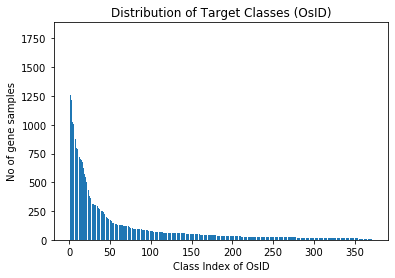

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=40, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/40
1846/1846 [==============================] - 10s 4ms/step - loss: 5.0019 - accuracy: 0.0413 - val_loss: 4.8537 - val_accuracy: 0.0647
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.3664 - accuracy: 0.1046 - val_loss: 4.2172 - val_accuracy: 0.1300
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9556 - accuracy: 0.1266 - val_loss: 3.9457 - val_accuracy: 0.1523
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6997 - accuracy: 0.1689 - val_loss: 3.7734 - val_accuracy: 0.1938
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4725 - accuracy: 0.2114 - val_loss: 3.5200 - val_accuracy: 0.2462
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2632 - accuracy: 0.2409 - val_loss: 3.3609 - val_accuracy: 0.3094
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0841 - accuracy: 0.27

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.9339 - accuracy: 0.0526 - val_loss: 4.4683 - val_accuracy: 0.0856
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7509 - accuracy: 0.2429 - val_loss: 3.4145 - val_accuracy: 0.3237
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8967 - accuracy: 0.4119 - val_loss: 2.8460 - val_accuracy: 0.4673
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3074 - accuracy: 0.5046 - val_loss: 2.3324 - val_accuracy: 0.5311
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8579 - accuracy: 0.5629 - val_loss: 2.0484 - val_accuracy: 0.5762
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6071 - accuracy: 0.5961 - val_loss: 1.8889 - val_accuracy: 0.6011
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4618 - accuracy: 0.6159 - val_loss: 1.8257 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.9771 - accuracy: 0.0503 - val_loss: 4.6280 - val_accuracy: 0.0647
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1781 - accuracy: 0.1129 - val_loss: 3.9763 - val_accuracy: 0.1615
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4533 - accuracy: 0.2969 - val_loss: 3.2323 - val_accuracy: 0.3551
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6814 - accuracy: 0.4274 - val_loss: 2.6241 - val_accuracy: 0.4904
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1761 - accuracy: 0.5076 - val_loss: 2.3288 - val_accuracy: 0.5384
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8350 - accuracy: 0.5636 - val_loss: 2.1124 - val_accuracy: 0.5593
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6037 - accuracy: 0.6091 - val_loss: 1.9318 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 12s 4ms/step - loss: 4.9233 - accuracy: 0.0600 - val_loss: 4.3815 - val_accuracy: 0.1353
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7312 - accuracy: 0.2656 - val_loss: 3.5072 - val_accuracy: 0.3314
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0070 - accuracy: 0.4045 - val_loss: 2.9770 - val_accuracy: 0.4341
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4841 - accuracy: 0.4824 - val_loss: 2.5617 - val_accuracy: 0.4931
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0872 - accuracy: 0.5431 - val_loss: 2.3013 - val_accuracy: 0.5582
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7928 - accuracy: 0.5995 - val_loss: 2.0554 - val_accuracy: 0.6125
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5828 - accuracy: 0.6347 - val_loss: 1.9439 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.9478 - accuracy: 0.0492 - val_loss: 4.4572 - val_accuracy: 0.0647
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8254 - accuracy: 0.2341 - val_loss: 3.4946 - val_accuracy: 0.3459
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9699 - accuracy: 0.4083 - val_loss: 2.8607 - val_accuracy: 0.4612
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3510 - accuracy: 0.5183 - val_loss: 2.3799 - val_accuracy: 0.5833
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8957 - accuracy: 0.5933 - val_loss: 2.0237 - val_accuracy: 0.6330
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5842 - accuracy: 0.6397 - val_loss: 1.8721 - val_accuracy: 0.6240
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3923 - accuracy: 0.6679 - val_loss: 1.7294 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 12s 4ms/step - loss: 4.5942 - accuracy: 0.0731 - val_loss: 4.0617 - val_accuracy: 0.1118
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5156 - accuracy: 0.2712 - val_loss: 3.2497 - val_accuracy: 0.4073
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6394 - accuracy: 0.4682 - val_loss: 2.5132 - val_accuracy: 0.5131
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9925 - accuracy: 0.5738 - val_loss: 2.0641 - val_accuracy: 0.6125
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6134 - accuracy: 0.6282 - val_loss: 1.8412 - val_accuracy: 0.6453
Epoch 6/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3777 - accuracy: 0.6653 - val_loss: 1.6132 - val_accuracy: 0.6774
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2257 - accuracy: 0.6882 - val_loss: 1.4975 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 11s 4ms/step - loss: 4.5687 - accuracy: 0.0845 - val_loss: 4.0741 - val_accuracy: 0.1505
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4497 - accuracy: 0.2768 - val_loss: 3.1317 - val_accuracy: 0.3795
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5882 - accuracy: 0.4667 - val_loss: 2.5420 - val_accuracy: 0.5179
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0285 - accuracy: 0.5600 - val_loss: 2.1114 - val_accuracy: 0.6068
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6466 - accuracy: 0.6304 - val_loss: 1.8224 - val_accuracy: 0.6378
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3954 - accuracy: 0.6734 - val_loss: 1.6616 - val_accuracy: 0.6711
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2371 - accuracy: 0.7008 - val_loss: 1.5400 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4867 - accuracy: 0.0920 - val_loss: 4.0010 - val_accuracy: 0.1333
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5454 - accuracy: 0.1886 - val_loss: 3.3843 - val_accuracy: 0.2869
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8237 - accuracy: 0.4176 - val_loss: 2.7416 - val_accuracy: 0.4662
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1968 - accuracy: 0.5371 - val_loss: 2.3161 - val_accuracy: 0.5395
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7951 - accuracy: 0.6019 - val_loss: 2.0086 - val_accuracy: 0.6022
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4943 - accuracy: 0.6663 - val_loss: 1.7788 - val_accuracy: 0.6768
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2851 - accuracy: 0.7076 - val_loss: 1.6258 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 14s 4ms/step - loss: 4.4660 - accuracy: 0.0948 - val_loss: 3.9527 - val_accuracy: 0.1844
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3814 - accuracy: 0.2628 - val_loss: 3.0779 - val_accuracy: 0.3745
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5232 - accuracy: 0.4660 - val_loss: 2.4250 - val_accuracy: 0.5626
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9362 - accuracy: 0.6020 - val_loss: 2.0007 - val_accuracy: 0.6438
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5395 - accuracy: 0.6743 - val_loss: 1.7248 - val_accuracy: 0.6834
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2809 - accuracy: 0.7133 - val_loss: 1.5911 - val_accuracy: 0.6862
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1095 - accuracy: 0.7382 - val_loss: 1.4230 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 12s 4ms/step - loss: 4.6489 - accuracy: 0.0746 - val_loss: 4.1288 - val_accuracy: 0.1551
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6461 - accuracy: 0.1820 - val_loss: 3.4928 - val_accuracy: 0.2438
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0339 - accuracy: 0.3310 - val_loss: 2.9658 - val_accuracy: 0.4002
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3383 - accuracy: 0.4852 - val_loss: 2.3497 - val_accuracy: 0.5586
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7799 - accuracy: 0.5960 - val_loss: 1.9434 - val_accuracy: 0.6334
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4330 - accuracy: 0.6654 - val_loss: 1.7008 - val_accuracy: 0.6510
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2150 - accuracy: 0.7064 - val_loss: 1.5847 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.5854 - accuracy: 0.0773 - val_loss: 4.1622 - val_accuracy: 0.1190
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6958 - accuracy: 0.1694 - val_loss: 3.4175 - val_accuracy: 0.2689
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8305 - accuracy: 0.3917 - val_loss: 2.6585 - val_accuracy: 0.4473
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1225 - accuracy: 0.5537 - val_loss: 2.1164 - val_accuracy: 0.6013
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6322 - accuracy: 0.6403 - val_loss: 1.7586 - val_accuracy: 0.6609
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3334 - accuracy: 0.6847 - val_loss: 1.5420 - val_accuracy: 0.6774
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1451 - accuracy: 0.7170 - val_loss: 1.4192 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 19s 7ms/step - loss: 4.4966 - accuracy: 0.0869 - val_loss: 4.0524 - val_accuracy: 0.1393
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6426 - accuracy: 0.1853 - val_loss: 3.4347 - val_accuracy: 0.2519
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8737 - accuracy: 0.3587 - val_loss: 2.6779 - val_accuracy: 0.4471
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1967 - accuracy: 0.5075 - val_loss: 2.1958 - val_accuracy: 0.5646
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7861 - accuracy: 0.5884 - val_loss: 1.9053 - val_accuracy: 0.6031
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4931 - accuracy: 0.6481 - val_loss: 1.8310 - val_accuracy: 0.5967
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3013 - accuracy: 0.6771 - val_loss: 1.5548 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4589 - accuracy: 0.0878 - val_loss: 3.9982 - val_accuracy: 0.1366
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6132 - accuracy: 0.1748 - val_loss: 3.5099 - val_accuracy: 0.2068
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0837 - accuracy: 0.2974 - val_loss: 2.9368 - val_accuracy: 0.3910
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5118 - accuracy: 0.4214 - val_loss: 2.4973 - val_accuracy: 0.4651
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1235 - accuracy: 0.4953 - val_loss: 2.2345 - val_accuracy: 0.5193
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8230 - accuracy: 0.5553 - val_loss: 1.9699 - val_accuracy: 0.5707
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5858 - accuracy: 0.6012 - val_loss: 1.8007 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.5594 - accuracy: 0.0794 - val_loss: 4.0865 - val_accuracy: 0.1074
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6589 - accuracy: 0.1831 - val_loss: 3.5157 - val_accuracy: 0.2396
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0059 - accuracy: 0.3438 - val_loss: 2.8740 - val_accuracy: 0.3998
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4271 - accuracy: 0.4512 - val_loss: 2.4507 - val_accuracy: 0.5105
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0336 - accuracy: 0.5075 - val_loss: 2.1479 - val_accuracy: 0.5160
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7417 - accuracy: 0.5630 - val_loss: 1.9534 - val_accuracy: 0.5765
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5349 - accuracy: 0.6061 - val_loss: 1.7672 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.5372 - accuracy: 0.0890 - val_loss: 4.0868 - val_accuracy: 0.1256
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7227 - accuracy: 0.1708 - val_loss: 3.5817 - val_accuracy: 0.1989
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1045 - accuracy: 0.3165 - val_loss: 2.9258 - val_accuracy: 0.3941
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4656 - accuracy: 0.4665 - val_loss: 2.4645 - val_accuracy: 0.5058
Epoch 5/40
1846/1846 [==============================] - 8s 5ms/step - loss: 2.0461 - accuracy: 0.5419 - val_loss: 2.1466 - val_accuracy: 0.5593
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7704 - accuracy: 0.5767 - val_loss: 1.9666 - val_accuracy: 0.5655
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5553 - accuracy: 0.6175 - val_loss: 1.7823 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 12s 4ms/step - loss: 4.6162 - accuracy: 0.0751 - val_loss: 4.1487 - val_accuracy: 0.0937
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7093 - accuracy: 0.1682 - val_loss: 3.5323 - val_accuracy: 0.2229
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0384 - accuracy: 0.3375 - val_loss: 2.9471 - val_accuracy: 0.3699
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4657 - accuracy: 0.4612 - val_loss: 2.5340 - val_accuracy: 0.4766
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0464 - accuracy: 0.5312 - val_loss: 2.1863 - val_accuracy: 0.5338
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7709 - accuracy: 0.5723 - val_loss: 2.0063 - val_accuracy: 0.5688
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5683 - accuracy: 0.6067 - val_loss: 1.8211 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 4ms/step - loss: 4.7759 - accuracy: 0.0679 - val_loss: 4.3203 - val_accuracy: 0.1133
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9081 - accuracy: 0.1319 - val_loss: 3.7436 - val_accuracy: 0.2029
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2601 - accuracy: 0.2820 - val_loss: 3.1243 - val_accuracy: 0.3525
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5996 - accuracy: 0.4319 - val_loss: 2.5860 - val_accuracy: 0.4763
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0957 - accuracy: 0.5148 - val_loss: 2.2099 - val_accuracy: 0.5545
Epoch 6/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7730 - accuracy: 0.5725 - val_loss: 1.9917 - val_accuracy: 0.5831
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5536 - accuracy: 0.6116 - val_loss: 1.8259 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 12s 4ms/step - loss: 4.7697 - accuracy: 0.0653 - val_loss: 4.2711 - val_accuracy: 0.0862
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8956 - accuracy: 0.1521 - val_loss: 3.7467 - val_accuracy: 0.1765
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4326 - accuracy: 0.2136 - val_loss: 3.3499 - val_accuracy: 0.2559
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9794 - accuracy: 0.3012 - val_loss: 2.9452 - val_accuracy: 0.2950
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5500 - accuracy: 0.3970 - val_loss: 2.5659 - val_accuracy: 0.4537
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2384 - accuracy: 0.4601 - val_loss: 2.3320 - val_accuracy: 0.4840
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0078 - accuracy: 0.5156 - val_loss: 2.1667 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 5ms/step - loss: 4.9001 - accuracy: 0.0531 - val_loss: 4.6097 - val_accuracy: 0.0737
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 4.1663 - accuracy: 0.1236 - val_loss: 3.9877 - val_accuracy: 0.1652
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6827 - accuracy: 0.1872 - val_loss: 3.6451 - val_accuracy: 0.1991
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3589 - accuracy: 0.2176 - val_loss: 3.3584 - val_accuracy: 0.2202
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0279 - accuracy: 0.2860 - val_loss: 3.0230 - val_accuracy: 0.3331
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6532 - accuracy: 0.3763 - val_loss: 2.6856 - val_accuracy: 0.3899
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3338 - accuracy: 0.4381 - val_loss: 2.4344 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 5ms/step - loss: 4.8774 - accuracy: 0.0576 - val_loss: 4.5698 - val_accuracy: 0.0735
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2421 - accuracy: 0.1167 - val_loss: 4.0836 - val_accuracy: 0.1696
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7965 - accuracy: 0.1663 - val_loss: 3.7666 - val_accuracy: 0.1866
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5085 - accuracy: 0.1980 - val_loss: 3.5212 - val_accuracy: 0.2044
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.2687 - accuracy: 0.2316 - val_loss: 3.3465 - val_accuracy: 0.2543
Epoch 6/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0135 - accuracy: 0.2959 - val_loss: 3.0730 - val_accuracy: 0.3100
Epoch 7/40
1846/1846 [==============================] - 8s 5ms/step - loss: 2.7309 - accuracy: 0.3523 - val_loss: 2.8471 - val_accuracy

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

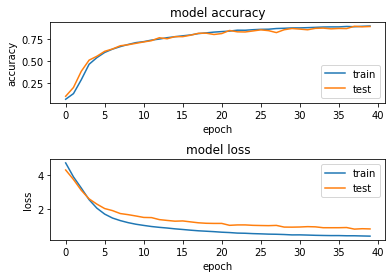

Final Test Accuracy: 0.9172993302345276


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 2s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.99      1.00      0.99       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.99      1.00      0.99       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       0.99      1.00      0.99       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os07g0476500         332              101       False
1  Os01g0741900         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.439
1,2,0.801
2,3,0.824
3,4,0.794
4,5,0.846
5,6,0.827
6,7,0.865
7,8,0.813
8,9,0.880
9,10,0.886
